<a href="https://colab.research.google.com/github/amadousysada/scoring-model/blob/master/03_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    IV - Modélisation
</p>

# Sommaire


1.   [Introduction](#introduction)
2.   [Import des Librairies](li)
3.   [Préparation des données](#preparation-des-donnees)
  - 3.1.  [Chargement des données]()
  - 3.2.  [Equilibrage des classes]()
4.   [Exploration des modéles](#modelisation)
  - 4.1.  [Dummy Classifier]()
  - 4.2.  [RandomForest]()
  - 4.3.  [Logistic Regression]()
  - 4.4.  [LightGBM]()
  - 4.5.  [XGBoost]()
  - 4.6.  [Naive Baise]()
5.   [Comparaison des modéles](#comparaison)


# **1. Introduction**

L’objectif de cette modélisation est de construire un modèle de machine learning optimisé, capable de minimiser les pertes financières tout en maintenant une précision élevée. Pour ce faire, nous avons adopté une méthodologie rigoureuse, incluant la préparation des données, l’évaluation de plusieurs algorithmes et la sélection du modèle le plus performant.  

Étant donné la nature déséquilibrée des données (peu de cas de défaut comparés aux non-défauts), un équilibrage des classes est effectué grâce à la méthode **SMOTE** (Synthetic Minority Oversampling Technique). Cela permet de générer artificiellement des exemples minoritaires afin de garantir une répartition équitable entre les classes.  

Plusieurs modèles seront testés, allant d’un modèle de base, le **Dummy Classifier**, à des algorithmes avancés comme **Random Forest**, **Logistic Regression**, **LightGBM**, **XGBoost**, et **Naive Bayes**. Les performances des modèles sont évaluées à l’aide de plusieurs métriques, chacune offrant un éclairage spécifique sur la qualité des prédictions :  

- **AUC (Area Under the Curve)** : mesure la capacité d’un modèle à distinguer les classes, avec une valeur de 1 indiquant une parfaite séparation.  
- **F1-Score** : représente l’équilibre entre précision (precision) et rappel (recall) avec la formule :  
  **F1 = 2 × (precision × recall) / (precision + recall)**  
- **Précision (Precision)** : proportion de prédictions positives correctes parmi toutes les prédictions positives :  
  **Precision = TP / (TP + FP)**  
- **Rappel (Recall)** : capacité du modèle à identifier les cas positifs :  
  **Recall = TP / (TP + FN)**  
- **F2-Score** : variante du F1-Score, mettant davantage l’accent sur le rappel :  
  **F2 = (1 + 2²) × (precision × recall) / (2² × precision + recall)**  
- **Exactitude (Accuracy)** : proportion de prédictions correctes parmi toutes les prédictions :  
  **Accuracy = (TP + TN) / (TP + FP + FN + TN)**  
- **Score métier** : une métrique personnalisée pénalisant plus fortement les faux négatifs (FN) que les faux positifs (FP), avec la formule :  
  **Score métier = 10 × FN + FP**  

Ces métriques permettent une évaluation multidimensionnelle des performances des modèles, en tenant compte des implications métier et des aspects purement techniques. À l’issue de cette étude, une comparaison détaillée des résultats nous permettra de sélectionner le modèle offrant le meilleur compromis entre précision, rappel et minimisation des pertes financières.

# **2. Import des Librairies**

In [2]:
# Forcer l'installation de la version 1.5.2 pour palier à une regression de scikit-learn qui impacte la librairie xgboost
# Line vers l'issue https://github.com/scikit-learn/scikit-learn/issues/30479

!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import warnings
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc, make_scorer, confusion_matrix, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ConfusionMatrix
from collections import Counter

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **3. Préparation des données**

## 3.1 Chargement des données

In [4]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve vos cvs.

In [5]:
X_train = pd.read_csv(f"{folder_path}final_cleaned_app_train.csv")
X_test = pd.read_csv(f"{folder_path}final_cleaned_app_test.csv")

In [6]:
X_train.drop(columns=['SK_ID_CURR'], inplace=True)
X_test.drop(columns=['SK_ID_CURR'], inplace=True)

In [7]:
X_train['TARGET'].isna().sum()

0

In [8]:
# Fonction pour afficher le diagramme en camembert
def plot_pie_chart(values, classes, title, ax):
    #plt.figure(figsize=(6, 6))
    ax.pie(values, labels=classes, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
    ax.set_title(title)

TARGET
0    282686
1     24825
Name: count, dtype: int64


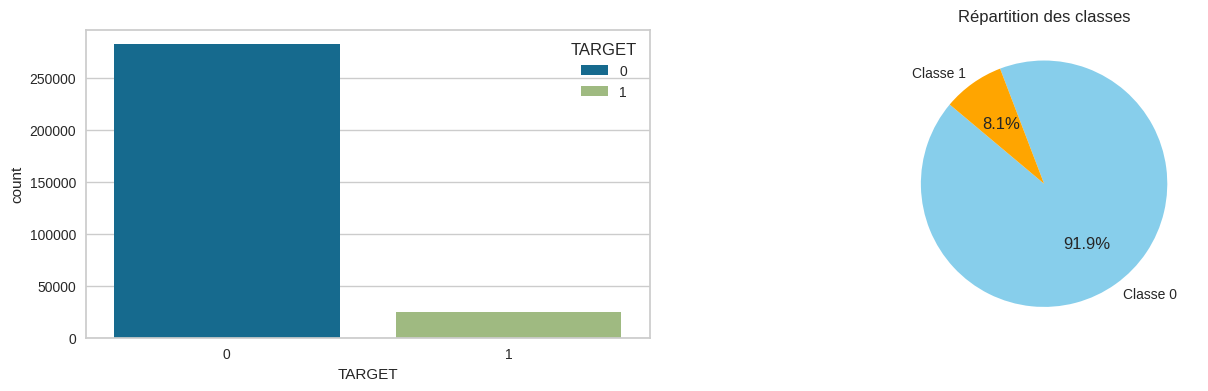

In [9]:
print(X_train.TARGET.value_counts())
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
plot_pie_chart(X_train.TARGET.value_counts(), ['Classe 0', 'Classe 1'], "Répartition des classes", ax1)
sns.countplot(data=X_train.TARGET.to_frame(), x='TARGET', ax=ax0, hue='TARGET')
xticks = ax0.xaxis.get_ticks_position()
ax0.xaxis.set_ticks([0, 1])
plt.show()

In [10]:
# Le ratio du desequilibre
print(f"imbalance_ratio = {24825 / 282686:.2%}")

imbalance_ratio = 8.78%


## 3.2 Equilibrage des classes

In [11]:
y = X_train['TARGET']
X_train.drop(labels='TARGET', axis=1, inplace=True)
X_train = SimpleImputer(strategy="median").fit_transform(X_train)
X_train, y = SMOTE(random_state=42).fit_resample(X_train, y)

TARGET
1    282686
0    282686
Name: count, dtype: int64


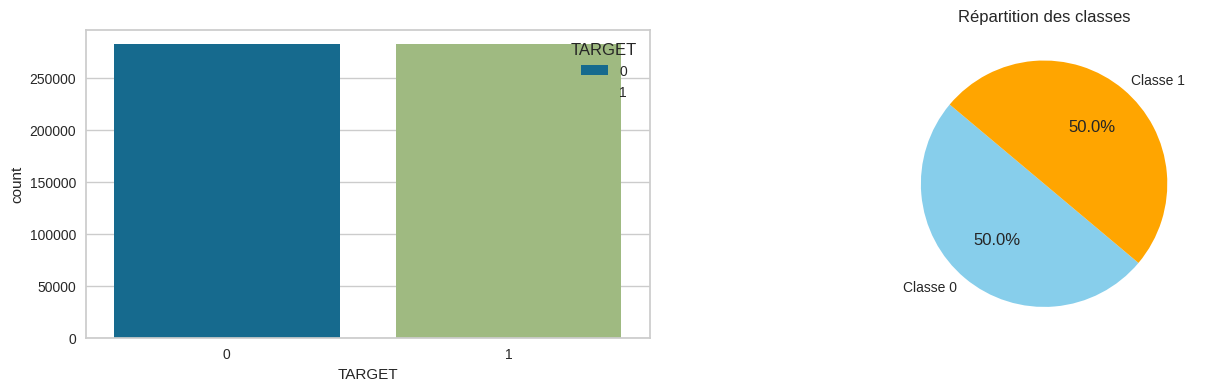

In [12]:
print(y.value_counts())
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
plot_pie_chart(y.value_counts(), ['Classe 0', 'Classe 1'], "Répartition des classes", ax1)
sns.countplot(data=y.to_frame(), x='TARGET', ax=ax0, hue='TARGET')
xticks = ax0.xaxis.get_ticks_position()
ax0.xaxis.set_ticks([0, 1])
plt.show()

In [13]:
# Séparation de l'ensemble X_train en 2 sous-ensembles
X_Xtrain, X_valid, y_train, y_valid = train_test_split(X_train, y, stratify=y, test_size=0.3, random_state=42)
X_Xtrain.shape, X_valid.shape

((395760, 14), (169612, 14))

In [14]:
# Fonction pour calculer le coût métier
def business_cost(y_true, y_pred):
    """
    Calcule le coût métier en fonction des faux négatifs et faux positifs.

    Paramètres :
    y_true (array-like) : Les vraies étiquettes (0 ou 1).
    y_pred (array-like) : Les prédictions du modèle (0 ou 1).

    Retourne :
    float : Le coût métier basé sur 10 * FN + FP.
    """

    thresholds = np.arange(0.0, 1.0, 0.01)  # Tester des seuils de 0 à 1
    best_score = float('inf')
    best_threshold = 0.5
    for threshold in thresholds:
        y_pred_binary = (y_pred > threshold).astype(int)

        # Matrice de confusion : [[TN, FP], [FN, TP]]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

        score = 10 * fn + fp  # Calcul du coût métier

        if score < best_score:
            best_score = score
            best_threshold = threshold
    return best_score

# Scorer pour le coût métier
business_scorer = make_scorer(business_cost, response_method="predict_proba", greater_is_better=False)

# **4. Exploration des modéles**

## 4.1. Dummy Classifier

Metric accuray: 0.5
Metric roc_auc: 0.5
Metric f1: 0.0
Metric Metier: 848060
Matrice de confusion:
[[84806     0]
 [84806     0]]


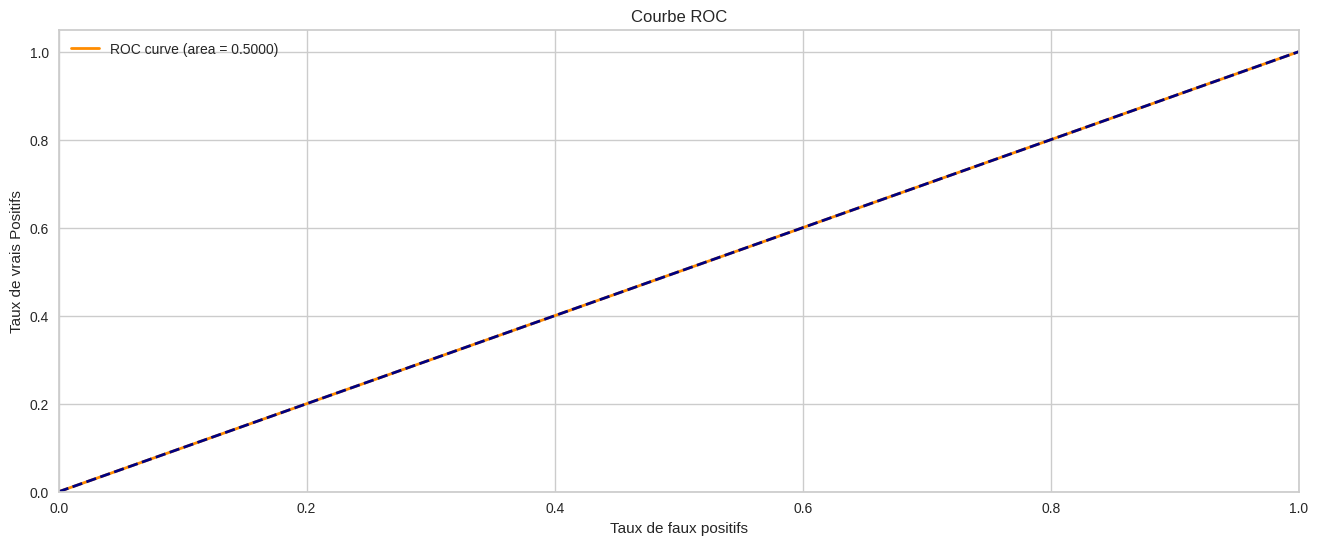

In [15]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_clf.fit(X_Xtrain, y_train)

# Prédictions
y_pred = dummy_clf.predict(X_valid)
y_prob = dummy_clf.predict_proba(X_valid)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_prob)
f1 = f1_score(y_valid, y_pred)

# Metric metier
cost = business_cost(y_valid, y_pred)

conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"Metric accuray: {accuracy}")
print(f"Metric roc_auc: {roc_auc}")
print(f"Metric f1: {f1}")
print(f"Metric Metier: {cost}")

print(f"Matrice de confusion:\n{conf_matrix}")

fpr, tpr, _ = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(16, 6))

# Visualiser la courbe ROC AUC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="upper left")
plt.show()

In [16]:

models = {
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    "Naive Bayes": GaussianNB()
}

# Grilles d'hyperparamètres
param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__class_weight": [None, "balanced"]
    },
    "Random Forest": {
        "model__n_estimators": [10, 100],
        "model__max_depth": [3, 6],
        "model__class_weight": [None, "balanced"]
    },
    "XGBoost": {
        "model__n_estimators": [10, 100],
        "model__learning_rate": [0.1, 0.2],
        "model__max_depth": [6, 10],
    },
    "LightGBM": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.1, 0.2, 0.3],
        "model__max_depth": [6, 10],
    },
    "SVM": {
        "model__C": [1, 10],
        "model__gamma": [1, 0.1]
    },
    "Naive Bayes": {
        "model__var_smoothing": [1e-9, 1e-8, 1e-7]
    }
}


In [17]:
# Résultats des modèles
model_results = {}
import os
if os.path.exists(f"{folder_path}grid_search_results.pkl"):
    with open(f"{folder_path}grid_search_results.pkl", "rb") as f:
        model_results = pickle.load(f)

In [18]:
# Un decorateur pour tracker le temps d'execution des modéles
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Temps d'entrainement du modèle {kwargs.get('model_name')}: {execution_time:.2f} secondes")
        return result
    return wrapper

In [19]:
@timer
def evaluate_model(model_name, X_train, y_train, X_valid, y_valid, force=True):
  """
  Entrainer un modèle, prédire sur l'ensemble de validation et évaluer les performances.

  Paramètres :
  model_name : Le nom modèle à entraîner.
  X_train, y_train : Les données d'entraînement.
  X_valid, y_valid : Les données de validation.

  Retourne :
  obj: Les résultats de l'évaluation du modèle.
  """
  print(f"Évaluation du modèle : {model_name}")

  # Pipeline avec SMOTE
  pipeline = ImbPipeline(steps=[
      ("scaler", StandardScaler()),
      ("model", models[model_name])
  ])

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # GridSearchCV
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=param_grids[model_name],
      scoring={
          "business_score": business_scorer,
          "AUC": "roc_auc",
          "F1": "f1",
          "Accuracy": "accuracy",
          "Recall": "recall",
          "Precision": "precision",
          "F2": make_scorer(fbeta_score, beta=2)
      },
      refit="business_score",  # Optimisation basée sur le score métier
      cv=cv,
      verbose=1,
      return_train_score=True
  )

  # Entraînement
  if force or model_name not in model_results:
    grid_search.fit(X_train, y_train)
    model_results[model_name] = grid_search
  else:
    grid_search = model_results[model_name]

  # Sauvegarder les resultats, pour eviter plus tard le coùt de calcul
  with open(f"{folder_path}grid_search_results.pkl", "wb") as f:
    pickle.dump(model_results, f)

  y_pred = grid_search.predict(X_valid)
  y_prob = grid_search.predict_proba(X_valid)[:, 1]

  # Résultats
  print("Meilleurs paramètres :", grid_search.best_params_)
  print("Meilleur score métier :", grid_search.best_score_)
  print("Matrice de confusion :", confusion_matrix(y_valid, y_pred))

  fpr, tpr, _ = roc_curve(y_valid, y_prob)
  roc_auc = auc(fpr, tpr)

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

  # Récupérer les scores pour chaque combinaison d'hyperparamètres
  scores = -grid_search.cv_results_['mean_test_business_score']
  params = grid_search.cv_results_['params']

  # Visualiser notre score metier
  ax0.plot(range(len(scores)), scores, marker='o')
  ax0.set_title("Score métier pour chaque combinaison d'hyperparamètres")
  ax0.set_xlabel("Index de la combinaison d'hyperparamètres")
  ax0.set_ylabel("Score métier (plus bas est meilleur)")
  ax0.set_xticks(range(len(scores)), labels=[str(p) for p in params], rotation=90)
  ax0.grid(True)

  # Visualiser la courbe ROC AUC
  ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
  ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax1.set_xlim([0.0, 1.0])
  ax1.set_ylim([0.0, 1.05])
  ax1.set_xlabel('Taux de faux positifs')
  ax1.set_ylabel('Taux de vrais Positifs')
  ax1.set_title('Courbe ROC')
  ax1.legend(loc="upper left")

  plt.show()

  print("-" * 50)
  return grid_search

In [20]:
def visualize_confusion_matrix(model, X_valid, y_valid, classes=['non_defaut_payment', 'defaut_payment']):
  sns.set_style("ticks")
  fig, ax = plt.subplots(figsize=(6, 4))
  cm = ConfusionMatrix(model, classes=classes)
  cm.fit(X_train, y_train)
  cm.score(X_valid, y_valid)
  cm.show()

## 4.2. RandomForest

Évaluation du modèle : Random Forest
Meilleurs paramètres : {'model__class_weight': None, 'model__max_depth': 6, 'model__n_estimators': 100}
Meilleur score métier : -33569.2
Matrice de confusion : [[74591 10215]
 [15136 69670]]


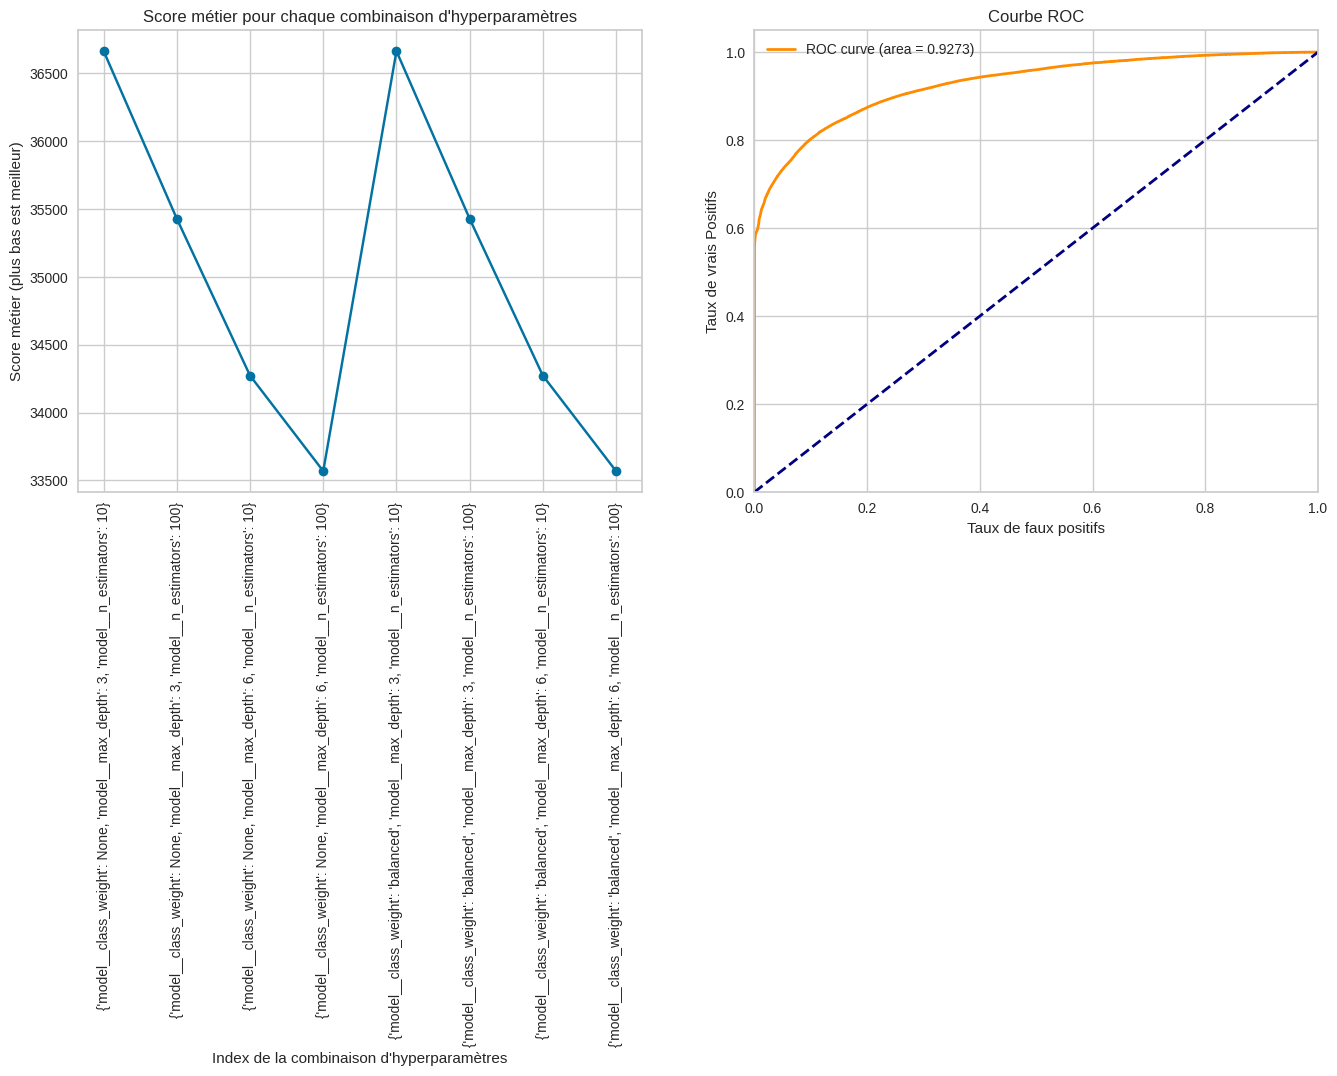

--------------------------------------------------
Temps d'entrainement du modèle Random Forest: 0.69 secondes


In [21]:
res = evaluate_model(model_name='Random Forest', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

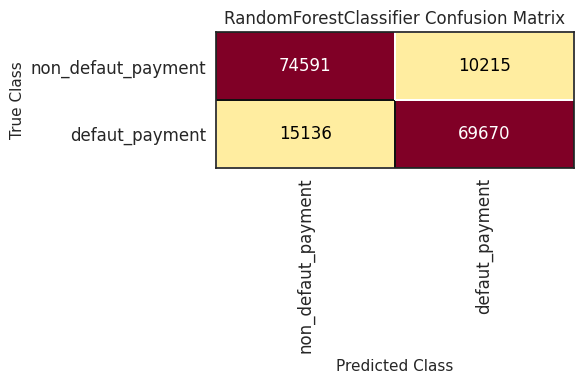

In [22]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

Le modéle avec **Random Forest** montre une bonne capacité à capturer les classes positives **(69,670 TP)**, ce qui est essentiel dans un problème de risque de défaut de paiement. Cependant, le nombre élevé de **FN (15,136)** impacte le score métier négativement.

Le modèle présente un bon compromis entre sensibilité et précision, avec un nombre relativement bas de **FP (10,215)**. Cela reflète une bonne gestion des erreurs de classe négative (classe 0).

Random Forest est performant et équilibre correctement la réduction des FN et FP. Cependant, un nombre significatif de FN suggère que ce modèle peut encore être optimisé pour minimiser davantage les risques métier.

## 4.3 Logistic Regression

Évaluation du modèle : Logistic Regression
Meilleurs paramètres : {'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l2'}
Meilleur score métier : -38566.2
Matrice de confusion : [[58292 26514]
 [27099 57707]]


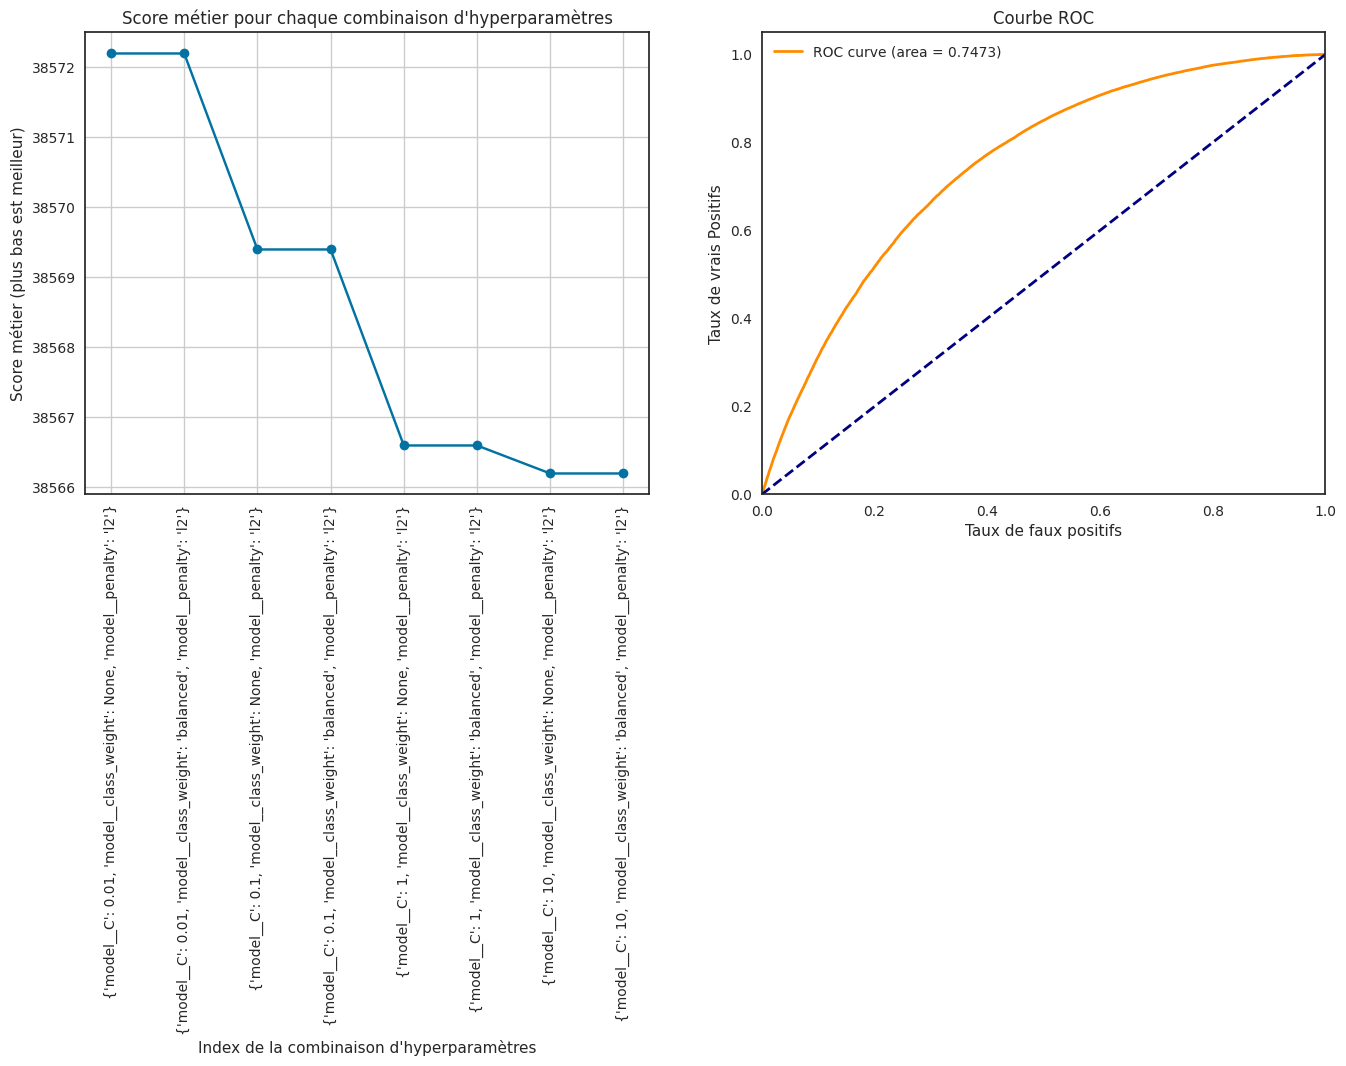

--------------------------------------------------
Temps d'entrainement du modèle Logistic Regression: 0.64 secondes


In [23]:
res = evaluate_model(model_name='Logistic Regression', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

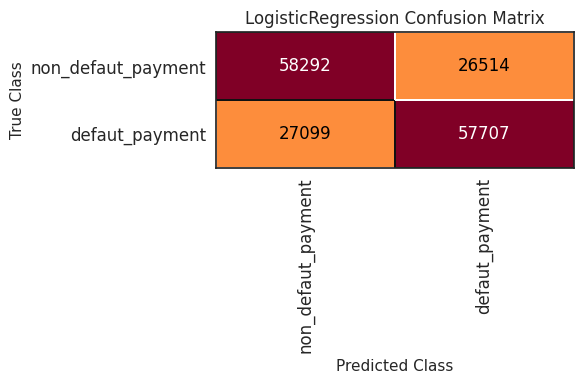

In [24]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

**Logistic Regression** capture un nombre relativement faible de ***TP (57,707)*** comparé à Random Forest. Le nombre élevé de ***FN (27,099)*** affecte gravement le score métier, car chaque FN est lourdement pénalisé.
Le modèle génère aussi plus de ***FP (26,514)***, ce qui diminue la précision globale.

La régression logistique semble moins adaptée dans cette tâche, probablement en raison de sa simplicité. Elle échoue à bien différencier les classes et génère un coût métier plus élevé.

## 4.4. LightGBM

Évaluation du modèle : LightGBM
Meilleurs paramètres : {'model__learning_rate': 0.2, 'model__max_depth': 10, 'model__n_estimators': 200}
Meilleur score métier : -25559.8
Matrice de confusion : [[83305  1501]
 [10389 74417]]


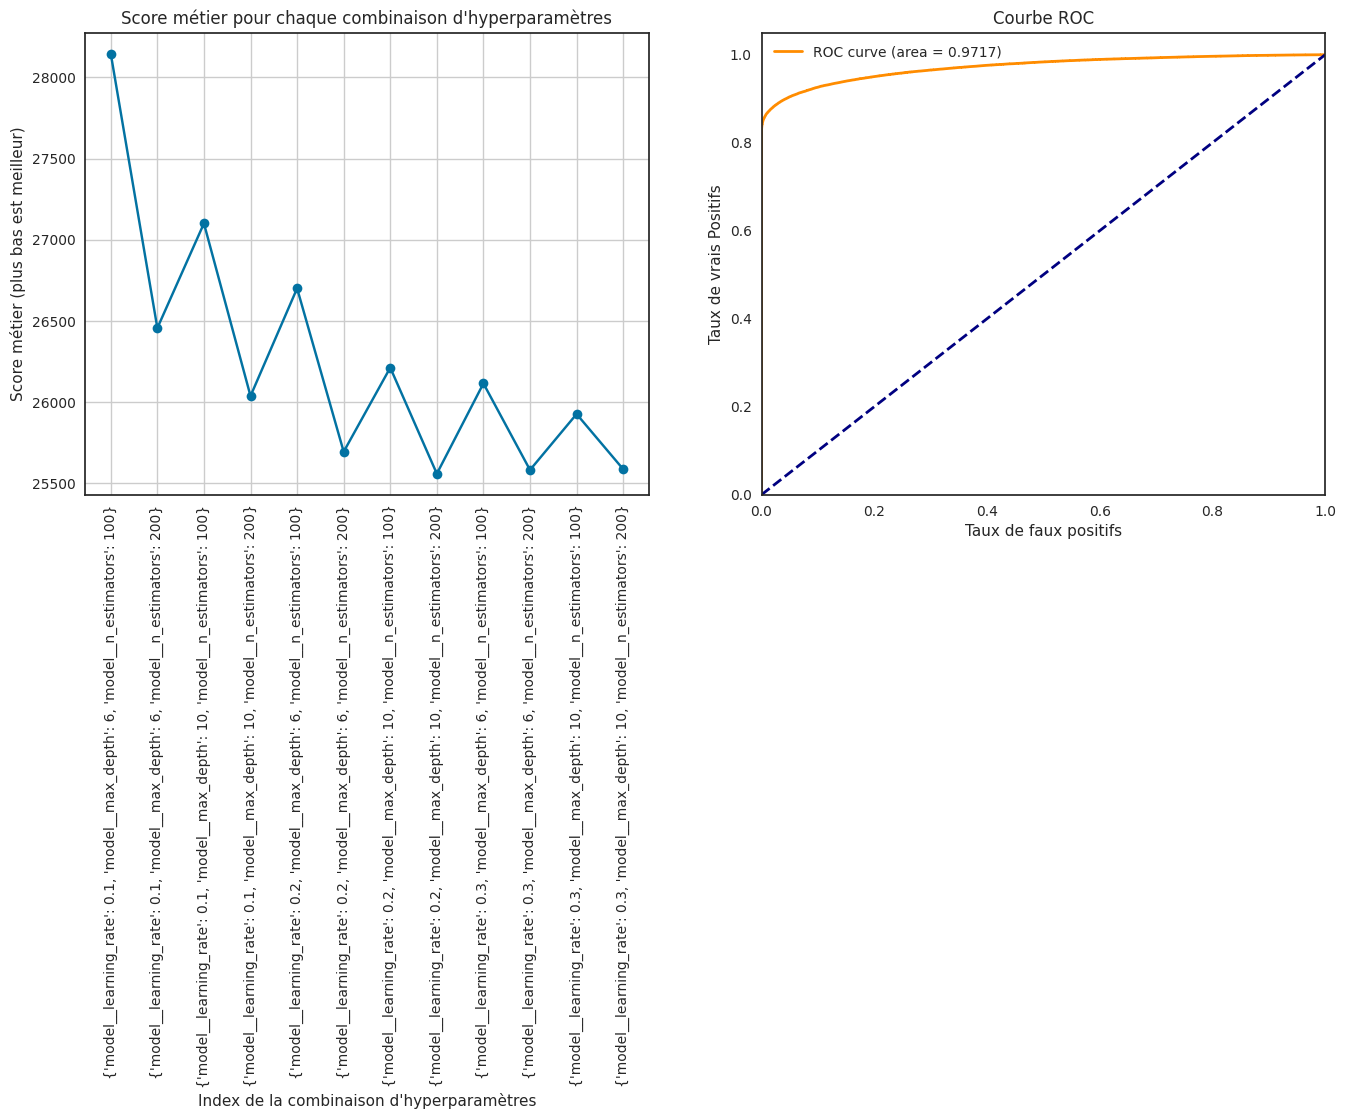

--------------------------------------------------
Temps d'entrainement du modèle LightGBM: 0.98 secondes


In [25]:
warnings.simplefilter("ignore", FutureWarning)
res = evaluate_model(model_name='LightGBM', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

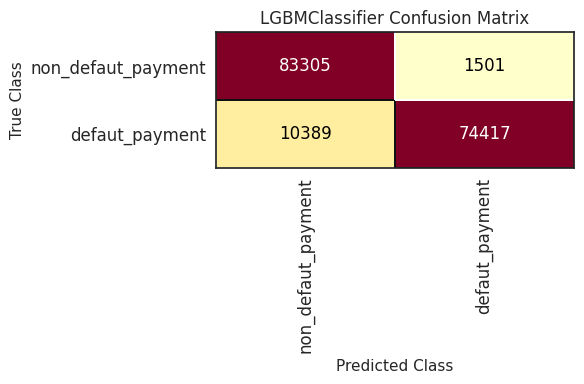

In [26]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

LightGBM excelle dans la réduction des FN (10,389), ce qui améliore considérablement le score métier. Cela montre une excellente sensibilité, essentielle pour réduire les risques associés aux défauts de paiement.
Le très faible nombre de FP (1,501) démontre une forte précision et limite les prédictions incorrectes pour la classe négative.

LightGBM est clairement plus performant que le RandomForest et  la Logistic Regression, équilibrant à la fois un faible coût métier et des métriques classiques. Il parvient à minimiser les deux types d'erreurs tout en capturant efficacement les cas positifs.

## 4.5. XGBoost

Évaluation du modèle : XGBoost
Meilleurs paramètres : {'model__learning_rate': 0.2, 'model__max_depth': 10, 'model__n_estimators': 100}
Meilleur score métier : -24965.4
Matrice de confusion : [[82709  2097]
 [10307 74499]]


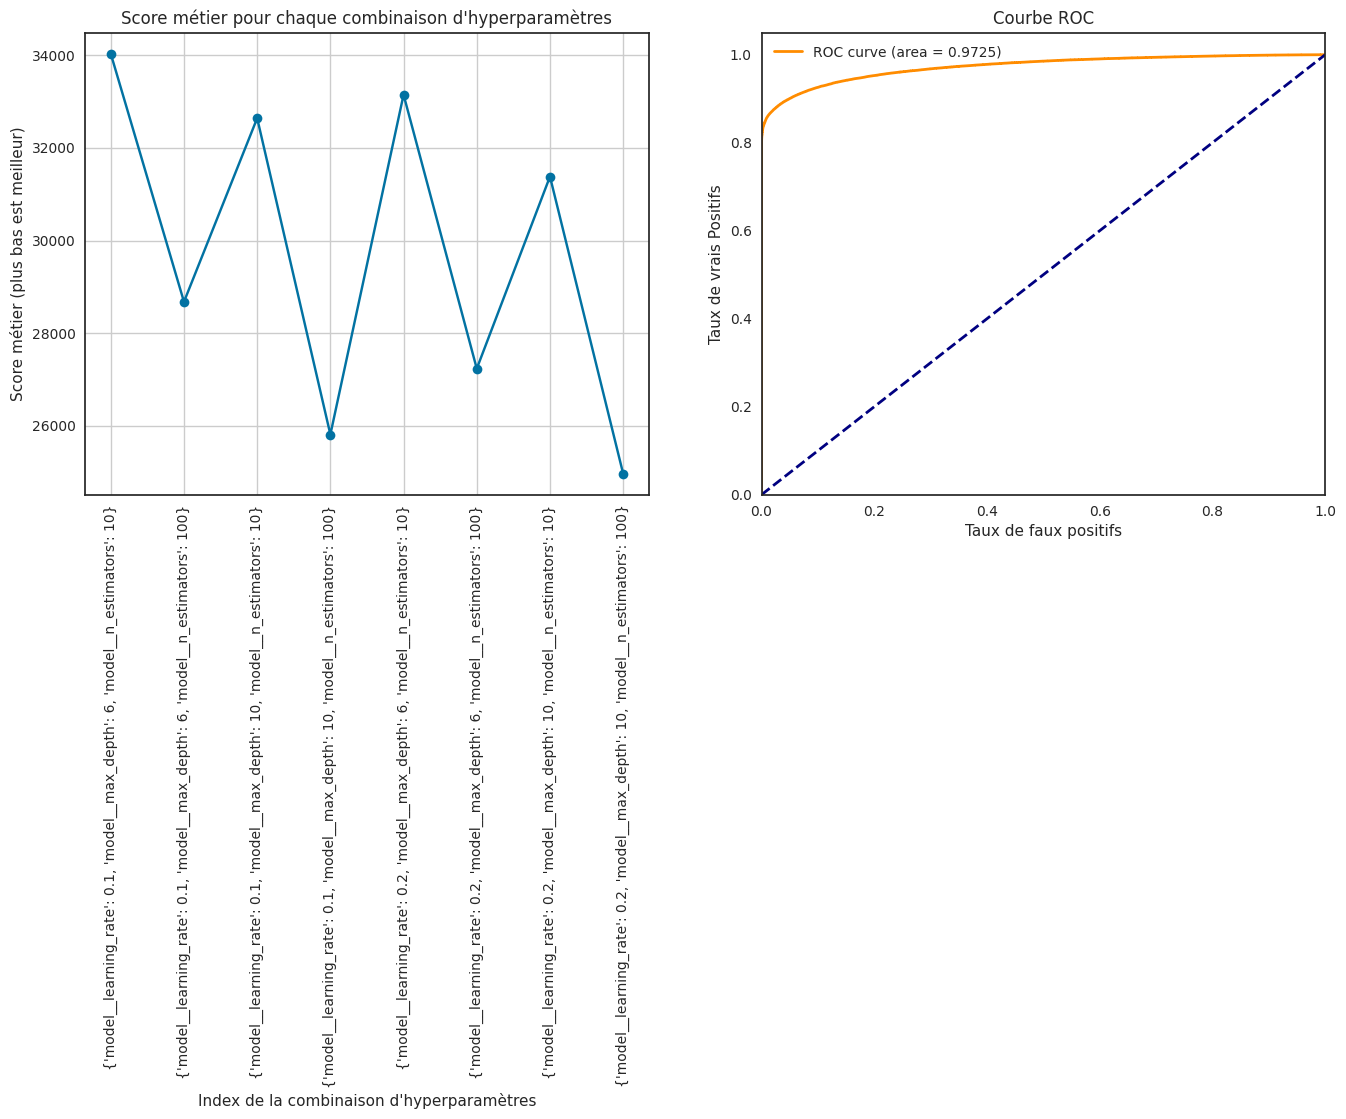

--------------------------------------------------
Temps d'entrainement du modèle XGBoost: 0.64 secondes


In [27]:
warnings.simplefilter("ignore", UserWarning)
res = evaluate_model(model_name='XGBoost', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

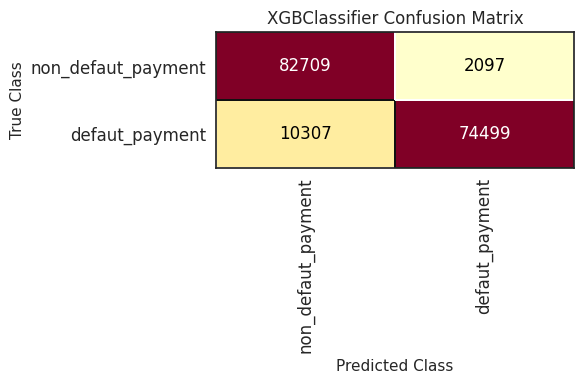

In [28]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

**XGBoost** montre des performances similaires à LightGBM, avec un très faible nombre de **FN (10,307)** et **FP (2,097)**. Cela reflète une bonne balance entre sensibilité et précision.
La différence de score métier est minime entre **XGBoost** et LightGBM, suggérant qu'ils fonctionnent presque aussi bien dans ce contexte.


**XGBoost** est également un excellent modèle, presque équivalent à LightGBM, avec un léger avantage sur le score métier. Il capture les cas positifs tout en maintenant les erreurs de prédiction à un niveau très bas.

## 4.6. Naive Baise

Évaluation du modèle : Naive Bayes
Meilleurs paramètres : {'model__var_smoothing': 1e-09}
Meilleur score métier : -39575.6
Matrice de confusion : [[49530 35276]
 [18961 65845]]


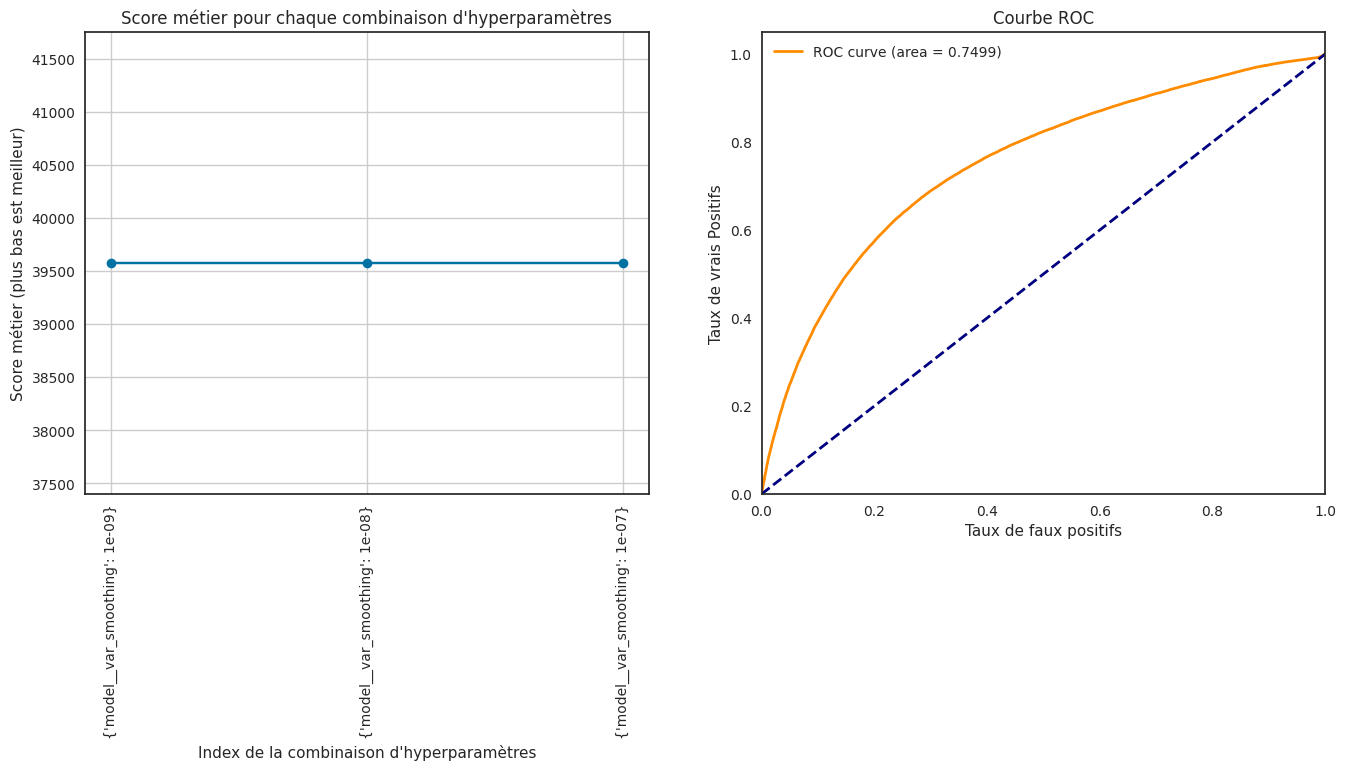

--------------------------------------------------
Temps d'entrainement du modèle Naive Bayes: 0.43 secondes


In [31]:
res = evaluate_model(model_name='Naive Bayes', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

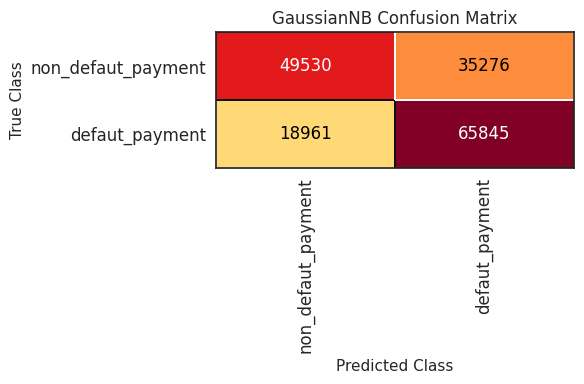

In [32]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

**Naive Bayes** génère un très grand nombre de FP (35,276), ce qui réduit considérablement la précision. Cela indique une incapacité à bien différencier les classes négatives.
Le nombre élevé de FN (18,961) reflète une faible sensibilité comparée à **LightGBM** ou **XGBoost**, ce qui affecte directement le score métier.

**Naive Bayes ** est le moins performant des modèles testés. Il est trop simpliste pour cette tâche complexe, générant des erreurs importantes dans les deux classes.

# **5. Comparaison des modéles**

In [33]:
metrics = [
    'business_score',
    'AUC',
    'F1',
    'Accuracy',
    'Recall',
    'Precision',
    'F2'
]

cv_results = {}
for key, grid_search in model_results.items():
    results = grid_search.cv_results_
    t = {}
    for metric in metrics:
      score = f"{results[f'mean_test_{metric}'][grid_search.best_index_]:.4f}"
      t[metric] = score
    cv_results[key] = t

metrics_df = pd.DataFrame(cv_results)
metrics_df.T

,business_score,AUC,F1,Accuracy,Recall,Precision,F2
Random Forest,-33569.2000,0.9265,0.8450,0.8504,0.8158,0.8765,0.8272
Logistic Regression,-38566.2000,0.7462,0.6825,0.6835,0.6804,0.6846,0.6812
LightGBM,-25559.8000,0.9710,0.9262,0.9301,0.8777,0.9804,0.8965
XGBoost,-24965.4000,0.9711,0.9218,0.9256,0.8772,0.9712,0.8945
Naive Bayes,-39575.6000,0.7495,0.7084,0.6801,0.7769,0.6510,0.7480


Dans cette étude, cinq modèles ont été évalués pour résoudre le problème de risque de défaut de crédit en optimisant un score métier basé sur le coût des faux négatifs (FN) et faux positifs (FP). Les performances ont été mesurées à l’aide de plusieurs métriques clés : score métier, AUC, F1-score, accuracy, recall, precision, et F2-score.

- **Random Forest** a obtenu un score métier de **-33,569.2**, avec une AUC de 0.9265 et un F1-score de 0.8450. Il montre un bon équilibre entre précision (0.8765) et rappel (0.8158), ce qui reflète une capacité correcte à détecter les cas positifs, mais le nombre encore significatif de FN affecte son score métier.

- **Logistic Regression** affiche un score métier de **-38,566.2**, nettement inférieur aux autres modèles. Son AUC de 0.7462 et son F1-score de 0.6825 montrent qu’il peine à différencier efficacement les classes. Malgré une précision de 0.6846, le modèle génère trop de FN, ce qui entraîne un coût métier élevé.

- **LightGBM** se distingue avec un score métier de **-25,559.8**, une AUC de 0.9710 et un F1-score de 0.9262, les meilleures performances globales. Son rappel de 0.8777 montre qu’il détecte efficacement les cas positifs, et sa précision de 0.9804 limite les FP. Le modèle présente également le meilleur F2-score (0.8965), indiquant qu’il favorise un rappel élevé tout en maintenant une précision solide.

- **XGBoost**, avec un score métier de **-24,965.4**, rivalise étroitement avec LightGBM. Il obtient une AUC de 0.9711 et un F1-score de 0.9218. Bien que légèrement inférieur à LightGBM en précision (0.9712) et F2-score (0.8945), il reste un excellent modèle avec des performances très proches.

- **Naive Bayes** est le modèle le moins performant avec un score métier de **-39,575.6**, une AUC de 0.7495 et un F1-score de 0.7084. Malgré un rappel de 0.7769, sa faible précision (0.6510) entraîne un coût élevé, reflétant des difficultés à bien différencier les classes.



Sur la base des résultats, **LightGBM** est le modèle le plus performant. Son excellent score métier, combiné à une AUC élevée et un F1-score supérieur, démontre sa capacité à optimiser les objectifs métier en réduisant efficacement les FN et FP.

Bien que **XGBoost** offre des performances similaires, LightGBM présente un meilleur F2-score et une précision légèrement supérieure, en faisant le choix idéal pour cette problématique de risque de crédit. Random Forest suit comme une alternative solide, mais reste moins efficace que LightGBM ou XGBoost. Logistic Regression et Naive Bayes sont clairement inadéquats pour ce problème, leurs performances étant nettement inférieures.